In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from pprint import pprint
import os.path as pth

import gzip
import pickle

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Flatten, Reshape
from tensorflow.keras.utils import Sequence

from sklearn.model_selection import train_test_split, KFold, GroupKFold

from util import downscale_img

from config import *

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
ROOT_DIR = '../data'
TRAIN_IMG_DIR = pth.join(ROOT_DIR, 'original/train_images')
TRAIN_DATA_DIR = ROOT_DIR

In [4]:
data = pd.read_feather(pth.join(TRAIN_DATA_DIR, 'train.feather'))

/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [5]:
image_groups = data.groupby('imageid')

s = image_groups[['mask_present']].sum().mask_present
s.name = 'nmasks'
data = data.merge(s, left_on=['imageid'], right_index=True)

In [6]:
data.head()

,imageid,classid,mask_present,nmasks
0,0002cc93b,1,True,1.0
1,0002cc93b,2,False,1.0
2,0002cc93b,3,False,1.0
3,0002cc93b,4,False,1.0
4,00031f466,1,False,0.0


In [7]:
with gzip.open(pth.join(TRAIN_DATA_DIR, 'train_masks.pickle.gz'), 'rb') as f:
    image_masks = pickle.load(f)

In [8]:
image_masks_scaled = {}
for k in image_masks:
    image_masks_scaled[k] = downscale_img(image_masks[k])

from loaders import BlockwiseImageLoader
n = 4
b = BlockwiseImageLoader(train_cv_image_names[0:10], image_groups, image_masks, n, 128, 64)
img_patches, mask_patches = b[0]
imgs = b.combine_patches(img_patches)

for i in range(n):
    name = train_cv_image_names[i]
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(imgs[i], cmap='gray')
    plt.show()


In [14]:
from models import SimpleAE, SimpleInception, UNet

OUTPUT_CHANNEL = 1
NUM_OUTPUTS = 4 if OUTPUT_CHANNEL is None else 1

model = UNet(4, 64, num_outputs=NUM_OUTPUTS)
model.build_model()
#model.summary()

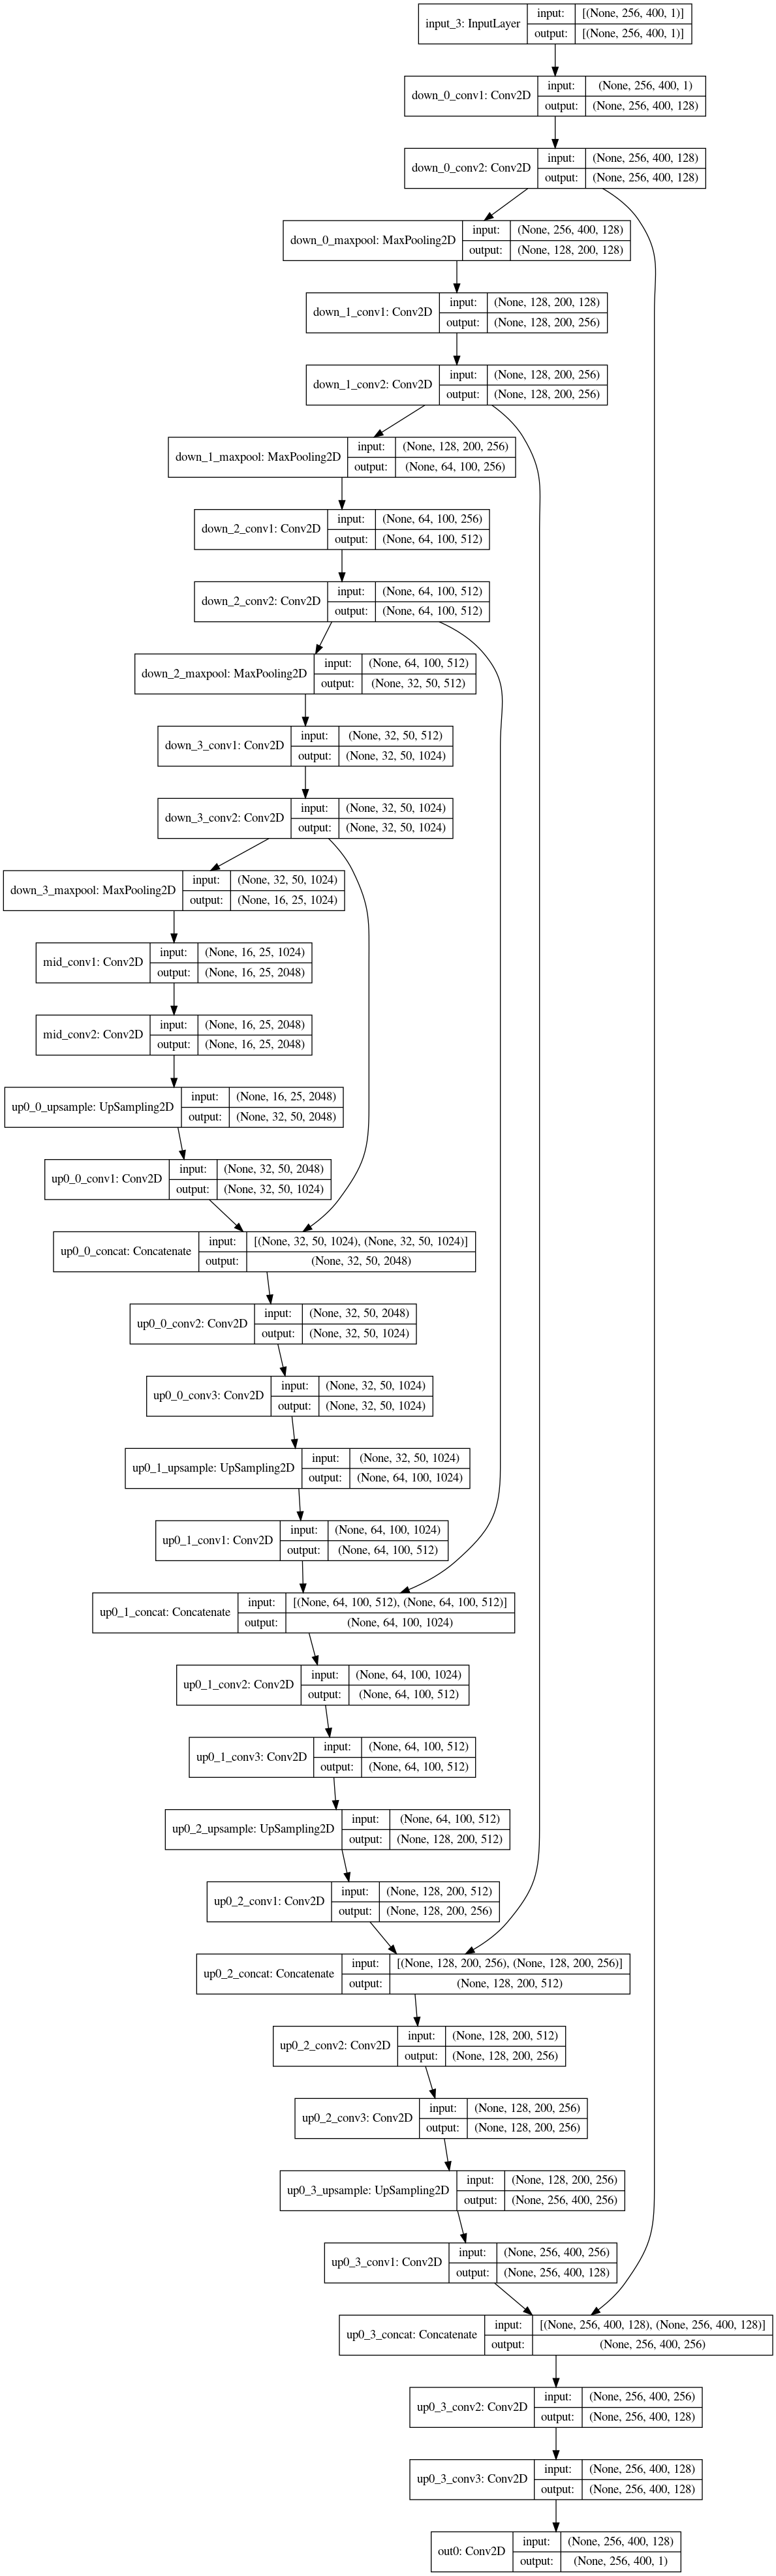

In [15]:
tf.keras.utils.plot_model(
    model.model,
    to_file='model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

In [16]:
if OUTPUT_CHANNEL is None:
    image_names = list(data[data.nmasks > 0].imageid.unique())[0:1000]
else:
    image_names = list(data[(data.classid == OUTPUT_CHANNEL) & data.mask_present].imageid.unique())[0:1000]

train_cv_image_names, test_image_names = train_test_split(image_names)
len(train_cv_image_names), len(test_image_names)

(672, 225)

from loaders import ImageLoader

n = 10
loader = ImageLoader(train_cv_image_names[0:n], image_groups, image_masks_scaled, 1)
for i in range(n):
    im = loader[i][0].squeeze()
    print(im.shape, im.min(), im.max())
    plt.figure()
    plt.imshow(im, cmap='gray')
    plt.show()

In [17]:
from loaders import ImageLoader, BlockwiseImageLoader
from config import *

BATCH_SIZE = 1
#PATCH_SIZE = 64
#PATCH_STRIDE = 32

kfold = KFold(5)

for train_indices, cv_indices in kfold.split(train_cv_image_names):
    train_image_names = [train_cv_image_names[i] for i in train_indices]
    cv_image_names = [train_cv_image_names[i] for i in cv_indices]
    print(f'{len(train_image_names)} training samples, {len(cv_image_names)} validation samples')
    model.fit_generator(
        generator=ImageLoader(train_image_names, image_groups, image_masks_scaled, 
                              BATCH_SIZE, output_channel=OUTPUT_CHANNEL),#, PATCH_SIZE, PATCH_STRIDE),
        validation_data=ImageLoader(cv_image_names, image_groups, image_masks_scaled, 
                                    BATCH_SIZE, output_channel=OUTPUT_CHANNEL),#, PATCH_SIZE, PATCH_STRIDE),
        epochs=1)

537 training samples, 135 validation samples


ResourceExhaustedError: OOM when allocating tensor with shape[3,3,2048,2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mid_conv2_2/kernel/Initializer/random_uniform/RandomUniform (defined at /home/gautham/work/kaggle/severstal_steel_defect/notebooks/models.py:127) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Original stack trace for 'mid_conv2_2/kernel/Initializer/random_uniform/RandomUniform':
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2854, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2880, in _run_cell
    return runner(coro)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3057, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3248, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-4b6df2475b30>", line 7, in <module>
    model.build_model()
  File "/home/gautham/work/kaggle/severstal_steel_defect/notebooks/models.py", line 25, in build_model
    inputs, outputs = self.get_io_layers()
  File "/home/gautham/work/kaggle/severstal_steel_defect/notebooks/models.py", line 167, in get_io_layers
    mid = self.conv_down(out, num_filters, skip_pool=True, level_name='mid')
  File "/home/gautham/work/kaggle/severstal_steel_defect/notebooks/models.py", line 127, in conv_down
    name=f'{level_name}_conv2')(conv)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 591, in __call__
    self._maybe_build(inputs)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 1881, in _maybe_build
    self.build(input_shapes)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/keras/layers/convolutional.py", line 165, in build
    dtype=self.dtype)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py", line 384, in add_weight
    aggregation=aggregation)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/training/tracking/base.py", line 663, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py", line 155, in make_variable
    shape=variable_shape if variable_shape.rank else None)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 259, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 220, in _variable_v1_call
    shape=shape)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 198, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    shape=shape)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 263, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 460, in __init__
    shape=shape)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/resource_variable_ops.py", line 604, in _init_from_args
    initial_value() if init_from_fn else initial_value,
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer_utils.py", line 135, in <lambda>
    init_val = lambda: initializer(shape, dtype=dtype)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py", line 533, in __call__
    shape, -limit, limit, dtype, seed=self.seed)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/random_ops.py", line 247, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/ops/gen_random_ops.py", line 820, in random_uniform
    name=name)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/home/gautham/apps/anaconda3/envs/kaggle/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
model.plot_history()

In [ ]:
model.plot_history(['val_loss'])

In [ ]:
names = test_image_names[0:10]
loader = ImageLoader(names, image_groups, image_masks_scaled,
                     BATCH_SIZE)#, PATCH_SIZE, PATCH_STRIDE)
results = model.predict_generator(generator=loader)
#results = loader.combine_mask_patches(results)

In [ ]:
for i, name in enumerate(names):
    im = plt.imread(pth.join(TRAIN_IMG_DIR, f'{name}.jpg')).astype('float32')[:, :, 0]
    im = downscale_img(im)
    
    print('')
    print(name)
    plt.figure(figsize=(16, 12))
    
    plt.subplot(3, 4, 1)
    plt.title(name)
    plt.imshow(im, cmap='gray')
    
    outputs = [1, 2, 3, 4] if OUTPUT_CHANNEL is None else [OUTPUT_CHANNEL] 
    for j in outputs:
        rows = data[(data.imageid == name) & (data.classid == j)]
        row = rows.iloc[0, :]

        if row.mask_present:
            mask_ref = image_masks_scaled[f'{name}_{j}']
        else:
            mask_ref = np.zeros((SCALED_HEIGHT, SCALED_WIDTH), dtype='uint8')
            
        plt.subplot(3, 4, 4 + j)
        plt.title(f'{name} {j} REF')
        plt.imshow(mask_ref, cmap='gray')
        
        #continue
        #mask_test = results[j - 1][i].squeeze()
        mask_test = results[i].squeeze()
        #mask_test = (mask_test > 0.5).astype('uint8')
        
        
        plt.subplot(3, 4, 8 + j)
        plt.title(f'{name} {j} TEST {np.sum(mask_ref != mask_test)}')
        plt.imshow(mask_test, cmap='gray')
        
    plt.show()
